In [1]:
# this notebook preprocesses the data to feed it to a forcasting model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("../data/COVID19_timeseries.csv")

In [4]:
data.head()

,country,date,infections,Lat,Long,deaths,recovered,Continent,bed_occupancy,ICU_beds,Population,population_world,age_0_to_64,age_15_to_64,age_over_65,month,day
0,Australia,1/24/20,0,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,24.0
1,Australia,1/25/20,0,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,25.0
2,Australia,1/26/20,4,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,26.0
3,Australia,1/27/20,5,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,27.0
4,Australia,1/28/20,5,-24.502867,141.055589,0,0,Oceania,NaN,NaN,25649909.0,0.0033,0.19,0.655,0.155,1.0,28.0


In [5]:
data.shape

(1887, 17)

In [6]:
# dummy encode the 'Country' and 'Continent' columns
data = pd.concat([data, pd.get_dummies(data['country'])], axis=1).drop('country', axis=1)

In [7]:
data = pd.concat([data, pd.get_dummies(data['Continent'])], axis=1).drop('Continent', axis=1)

In [8]:
# drop the date and population column 
data = data.drop(['date', 'Population'], axis=1)

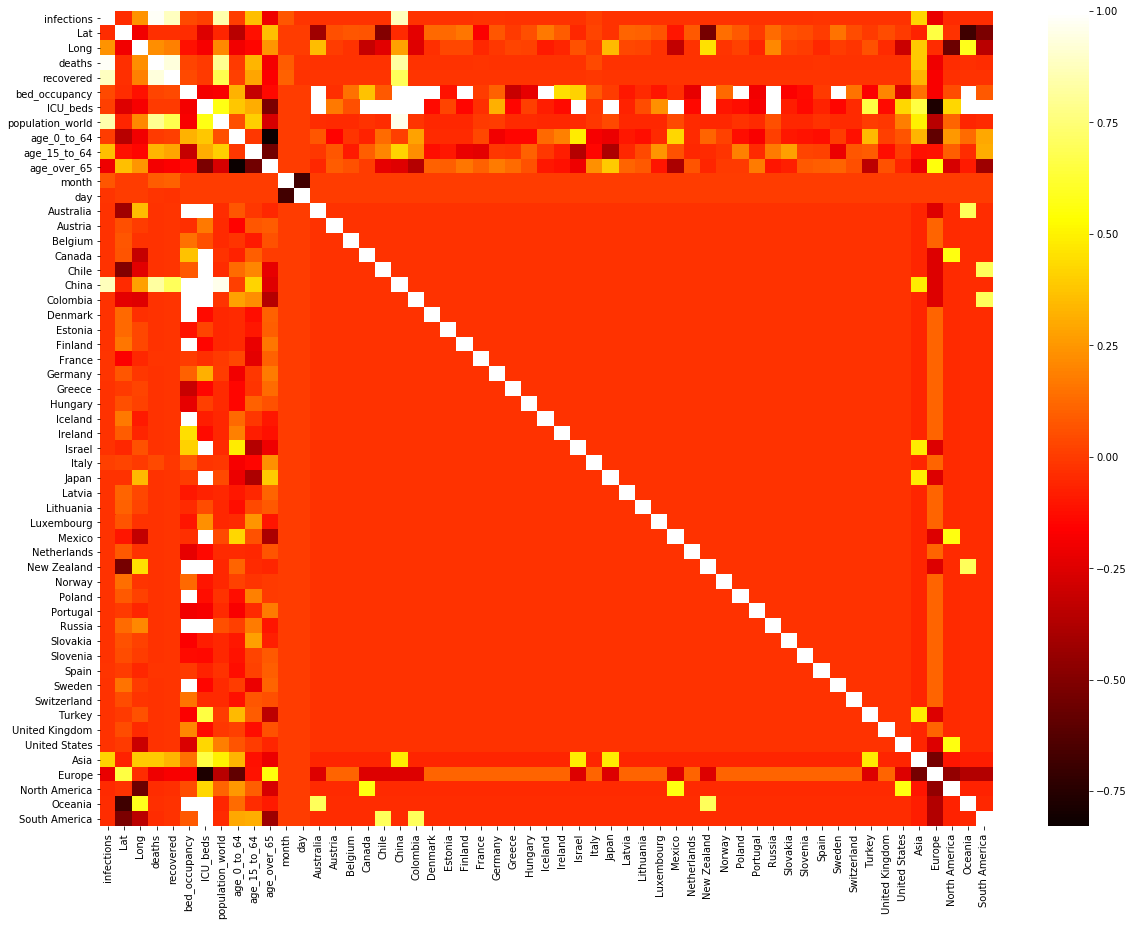

In [9]:
# visualize correlations between columns
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 15)
sns.heatmap(data.corr(), cmap='hot', ax=ax)

In [10]:
# bed_occupancy and ICU_beds contain NaNs values
# KNN impute both columns

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

In [11]:
imputer.fit(data)

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=3, weights='uniform')

In [12]:
column_names = data.columns

In [13]:
data = pd.DataFrame(imputer.transform(data), columns=column_names)

In [16]:
data.head()

,infections,Lat,Long,deaths,recovered,bed_occupancy,ICU_beds,population_world,age_0_to_64,age_15_to_64,...,Sweden,Switzerland,Turkey,United Kingdom,United States,Asia,Europe,North America,Oceania,South America
0,0.0,-24.502867,141.055589,0.0,0.0,0.755,46.0,0.0033,0.19,0.655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,-24.502867,141.055589,0.0,0.0,0.755,46.0,0.0033,0.19,0.655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.0,-24.502867,141.055589,0.0,0.0,0.755,46.0,0.0033,0.19,0.655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5.0,-24.502867,141.055589,0.0,0.0,0.755,46.0,0.0033,0.19,0.655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,-24.502867,141.055589,0.0,0.0,0.755,46.0,0.0033,0.19,0.655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
